## Лабораторная работа 10.
### Обработка голоса

ФИО: Монастырный Максим Александрович

Группа: М24-501 

In [1]:
import re
import wave
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import resample_poly

In [2]:
sns.set_theme()

In [3]:
DATA_DIR = Path("../data/speech")

AUDIO_PATH = DATA_DIR / "phoneme"

In [4]:
SYMBOL2STEM = {
    # ГЛАСНЫЕ
    # ударные
    "a": "а_уд_после_тв",
    "æ": "я_уд_после_м",
    "ä": "я_уд_после_м",
    "ɑ": "а_перед_л",
    "ɑ̟": "а_перед_л",
    "ˈə": "о_шва",
    "ъ": "о_шва",
    "e": "е_между_м",
    "ɛ": "е_перед_тв",
    "i": "и_перед_м",
    "ɨ": "ы",
    "o": "о",
    "ɵ̞": "е_шва_между_м",
    "u": "у",
    "ʉ": "у_между_м",
    # безударные
    "ɐ": "а_нач_перед_уд_в_зауд",
    "ʌ": "а_нач_перед_уд_в_зауд",
    "ə": "а_шва",
    "ɪ": "я_не_перед_м",
    "ь": "я_не_перед_м",
    "ɨ̟": "ыы",
    "ɯ̟": "ы_дифт",
    "ᵻ": "ыыы",
    "ɘ": "ы_после_ц",
    "ʊ": "уу",
    "ᵿ": "у_между_м",
    "ɪ̯": "о_неслог",
    "u̯": "в_неслог",
    # СОГЛАСНЫЕ
    "b": "б_тв",
    "bʲ": "б_м",
    "v": "в_тв",
    "vʲ": "в_м",
    "g": "г_тв",
    "gʲ": "г_м",
    "d": "д_тв",
    "dʲ": "д_м",
    "ʐ": "ж_тв",
    "ʑː": "ж_м",
    "z": "з_тв",
    "zʲ": "з_м",
    "j": "й",
    "k": "к_м",
    "kʲ": "к_м_мяг",
    "ɫ": "л_тв",
    "lʲ": "л_м",
    "m": "м_тв",
    "mʲ": "м_м",
    "n": "н_тв",
    "nʲ": "н_м",
    "p": "п_тв",
    "pʲ": "п_м",
    "r": "р_тв",
    "rʲ": "р_м",
    "s": "с_тв",
    "sʲ": "с_м",
    "t": "т_тв",
    "tʲ": "т_м",
    "f": "ф_тв",
    "fʲ": "ф_м",
    "x": "х_тв",
    "xʲ": "х_м",
    "ɣ": "г_тв_фрик",
    "ʣ": "дз",
    "ʨ": "ч_ты",
    "ʥ": "ч_м",
    "ʦ": "ц",
    "ʂ": "ш",
    "ɕː": "щ",
}

In [5]:
PAUSE_MS = {
    "|": 150,
    "||": 300,
    ",": 120,
    ".": 220,
    "!": 220,
    "?": 220,
}

Функции IO

In [6]:
def read_wav(path: Path):
    """
    Read a WAV file and return mono audio signal, sample rate, and number of channels.

    Args:
        path (Path): Path to the WAV file.

    Returns:
        x_mono (np.ndarray): Mono audio signal as a float32 numpy array in range [-1.0, 1.0].
        sr (int): Sample rate of the audio.
        n_channels (int): Number of channels in the original audio.
    """
    with wave.open(path.as_posix(), "rb") as wf:
        n_channels = wf.getnchannels()
        sr = wf.getframerate()
        sampwidth = wf.getsampwidth()
        n_frames = wf.getnframes()
        raw = wf.readframes(n_frames)

    if sampwidth == 1:
        x = np.frombuffer(raw, dtype=np.uint8).astype(np.float32)
        x = (x - 128.0) / 128.0
    elif sampwidth == 2:
        x = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
    elif sampwidth == 3:
        b = np.frombuffer(raw, dtype=np.uint8).reshape(-1, 3)
        x = (
            b[:, 0].astype(np.int32)
            | (b[:, 1].astype(np.int32) << 8)
            | (b[:, 2].astype(np.int32) << 16)
        )
        x = (x ^ (1 << 23)) - (1 << 23)
        x = x.astype(np.float32) / (1 << 23)
    elif sampwidth == 4:
        x = np.frombuffer(raw, dtype=np.int32).astype(np.float32) / 2147483648.0
    else:
        raise ValueError(f"Unsupported sampwidth={sampwidth}")

    x = x.reshape(-1, n_channels)
    if n_channels > 1:
        x_mono = x.mean(axis=1)
    else:
        x_mono = x[:, 0]

    return x_mono.astype(np.float32), int(sr), int(n_channels)


def write_wav_mono16(path: Path, x: np.ndarray, sr: int) -> None:
    """
    Write a mono audio signal to a WAV file in 16-bit PCM format.

    Args:
        path (Path): Path to save the WAV file.
        x (np.ndarray): Mono audio signal as a float32 numpy array in range [-1.0, 1.0].
        sr (int): Sample rate of the audio.
    """
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)

    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(x_i16.tobytes())

Функции для Фурье

In [7]:
def frame_signal(x: np.ndarray, frame_len: int, hop: int) -> np.ndarray:
    """
    Divide a 1D signal into overlapping frames.

    Args:
        x (np.ndarray): Input 1D signal.
        frame_len (int): Length of each frame.
        hop (int): Hop size between frames.

    Returns:
        np.ndarray: 2D array of shape (n_frames, frame_len) containing the framed signal.
    """
    if len(x) < frame_len:
        x = np.pad(x, (0, frame_len - len(x)))
    n_frames = 1 + (len(x) - frame_len) // hop
    shape = (n_frames, frame_len)
    strides = (x.strides[0] * hop, x.strides[0])
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides).copy()


def stft(x: np.ndarray, n_fft: int, hop: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Forward Short-Time Fourier Transform (STFT).

    Args:
        x (np.ndarray): Input 1D signal.
        n_fft (int): FFT size (frame length).
        hop (int): Hop size between frames.

    Returns:
        tuple[np.ndarray, np.ndarray]: STFT matrix and analysis window.
    """
    win = np.hanning(n_fft).astype(np.float32)
    frames = frame_signal(x, n_fft, hop) * win[None, :]
    X = np.fft.rfft(frames, n=n_fft, axis=1)
    return X, win


def istft(
    X: np.ndarray,
    win: np.ndarray,
    hop: int,
    length: int | None = None,
) -> np.ndarray:
    """
    Inverse Short-Time Fourier Transform (iSTFT).

    Args:
        X (np.ndarray): STFT matrix of shape (n_frames, n_bins).
        win (np.ndarray): Synthesis window.
        hop (int): Hop size between frames.
        length (int | None): Desired length of the output signal. If None, returns full length.

    Returns:
        np.ndarray: Reconstructed 1D signal.
    """
    n_frames, n_bins = X.shape
    n_fft = (n_bins - 1) * 2
    x_rec = np.zeros(n_frames * hop + n_fft, dtype=np.float32)
    wsum = np.zeros_like(x_rec)

    for i in range(n_frames):
        frame = np.fft.irfft(X[i], n=n_fft).astype(np.float32)
        start = i * hop
        x_rec[start : start + n_fft] += frame * win
        wsum[start : start + n_fft] += win**2

    nz = wsum > 1e-8
    x_rec[nz] /= wsum[nz]

    if length is not None:
        x_rec = x_rec[:length]
    return x_rec


def mag_db(X: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    """
    Convert magnitude spectrum to decibel (dB) scale.

    Args:
        X (np.ndarray): Input complex STFT matrix.
        eps (float): Small value to avoid log of zero.

    Returns:
        np.ndarray: Magnitude in dB.
    """
    M = np.abs(X)
    return 20.0 * np.log10(np.maximum(M, eps))

Дополнительные функции

In [8]:
def plot_spectrogram(
    X: np.ndarray,
    sample_rate: int,
    hop: int,
    title: str = "Spectrogram",
    path: Path = Path("spectrogram.png"),
    peak_tf: list = None,
) -> None:
    """
    Plot the magnitude spectrogram in dB scale.

    Args:
        X (np.ndarray): STFT matrix of shape (n_frames, n_bins).
        sample_rate (int): Sample rate of the signal.
        hop (int): Hop size between frames.
        title (str): Title of the plot.
    """
    n_frames, n_bins = X.shape
    n_fft = (n_bins - 1) * 2

    times = (np.arange(n_frames) * hop) / sample_rate
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / sample_rate)

    M_db = mag_db(X)

    plt.figure(figsize=(21, 10))
    plt.pcolormesh(times, freqs, M_db.T, shading="auto")
    plt.yscale("log")
    plt.ylim(max(20, freqs[1]), sample_rate / 2)
    plt.xlabel("Time, s")
    plt.ylabel("Frequency, Hz (log)")
    plt.title(title)

    if peak_tf is not None:
        tt = [p[1] for p in peak_tf]
        ff = [p[2] for p in peak_tf]
        plt.scatter(tt, ff, marker="x")

    cbar = plt.colorbar()
    cbar.set_label("Magnitude, dB")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.show()

Генерация аудио по транскрипции

In [9]:
def token_to_path(
    tok: str,
    stem2path: dict[str, Path],
    pause_ms: dict[str, int] = PAUSE_MS,
    token_to_filename: dict[str, str] = SYMBOL2STEM,
) -> Path | None:
    """
    Map a token to its corresponding audio file path.

    Args:
        tok (str): The token to map.
        stem2path (dict[str, Path]): Mapping from stem names to file paths.
        pause_ms (dict[str, int]): Mapping of pause tokens to their durations in milliseconds.
        token_to_filename (dict[str, str]): Mapping from tokens to filename stems.

    Returns:
        Path | None: The corresponding file path or None if not found or if it's a pause token.
    """
    if tok in pause_ms:
        return None

    tok = tok.strip()
    t = tok.replace("ˈ", "").replace("'", "")
    if token_to_filename:
        if tok in token_to_filename:
            t = token_to_filename[tok]
        elif t in token_to_filename:
            t = token_to_filename[t]

    if t.endswith(".wav"):
        t = Path(t).stem

    if t in stem2path:
        return stem2path[t]

    if t.lower() in stem2path:
        return stem2path[t.lower()]

    if t.upper() in stem2path:
        return stem2path[t.upper()]

    return None


def resample_if_needed(x: np.ndarray, sr_src: int, sr_dst: int) -> np.ndarray:
    """
    Resample the audio signal if the source and destination sample rates differ.

    Args:
        x (np.ndarray): Input audio signal.
        sr_src (int): Source sample rate.
        sr_dst (int): Destination sample rate.

    Returns:
        np.ndarray: Resampled audio signal.
    """
    if sr_src == sr_dst:
        return x.astype(np.float32, copy=False)

    g = np.gcd(sr_src, sr_dst)
    up, down = sr_dst // g, sr_src // g
    return resample_poly(x.astype(np.float32), up=up, down=down).astype(np.float32)

In [10]:
def synthesize_from_transcription(
    transcription: str | list[str],
    speech_dir: Path = AUDIO_PATH,
    sr_target: int | None = None,
    pause_ms: dict[str, int] = PAUSE_MS,
    crossfade_ms: float = 8.0,
    normalize_peak: float | None = 0.98,
    token_to_filename: dict[str, str] = SYMBOL2STEM,
) -> tuple[np.ndarray, int, dict]:
    """
    Synthesize audio from a transcription using a directory of speech tokens.

    Args:
        transcription (str | list[str]): Transcription as a string (each token separated by whitespace) or list of tokens.
        speech_dir (Path): Directory containing WAV files for each token. Defaults to AUDIO_PATH.
        sr_target (int | None): Target sample rate. If None, uses the sample rate of the first found token.
        pause_ms (dict[str, int]): Mapping of pause tokens to their durations in milliseconds. Defaults to PAUSE_MS.
        crossfade_ms (float): Duration of crossfade between segments in milliseconds.
        normalize_peak (float | None): Peak normalization level. If None, normalization is applied.
        token_to_filename (dict[str, str]): Mapping from transcription tokens to filenames (without .wav). Defaults to SYMBOL2STEM.

    Returns:
        tuple[np.ndarray, int, dict]: Synthesized audio signal, sample rate, and info dictionary.
    """
    if isinstance(transcription, str):
        tokens = re.findall(r"\S+", transcription.strip())
    else:
        tokens = list(transcription)

    wav_paths = list(speech_dir.glob("*.wav"))
    stem2path = {p.stem: p for p in wav_paths}

    token_paths = [
        token_to_path(
            tok,
            stem2path=stem2path,
            pause_ms=pause_ms,
            token_to_filename=token_to_filename,
        )
        for tok in tokens
    ]

    read_tokens = []

    for path in token_paths:
        data = None
        if path is not None:
            data = read_wav(path)
            if data is not None:
                if sr_target is None:
                    sr_target = data[1]

        read_tokens.append(data)

    sr_target = int(sr_target)
    cf = int(round(sr_target * (crossfade_ms / 1000.0)))

    used = []
    segments: list[np.ndarray] = []

    for tok_char, tok_data in zip(tokens, read_tokens):
        if tok_char in pause_ms:
            dur = int(round(sr_target * (pause_ms[tok_char] / 1000.0)))
            segments.append(np.zeros(dur, dtype=np.float32))
            used.append(tok_char)
            continue

        x, sr_src, _ = tok_data

        segments.append(resample_if_needed(x, int(sr_src), sr_target))
        used.append(tok_char)

    if not segments:
        raise ValueError("No valid token detected")

    y = segments[0].astype(np.float32, copy=True)
    for seg in segments[1:]:
        seg = seg.astype(np.float32, copy=False)

        if cf > 0 and len(y) > 0 and len(seg) > 0:

            overlap = min(cf, len(y), len(seg))

            if overlap > 0:
                w = np.linspace(0.0, 1.0, overlap, endpoint=False, dtype=np.float32)
                mixed = y[-overlap:] * (1.0 - w) + seg[:overlap] * w
                y = np.concatenate([y[:-overlap], mixed, seg[overlap:]])

            else:
                y = np.concatenate([y, seg])
        else:
            y = np.concatenate([y, seg])

    if normalize_peak is not None and len(y) > 0:
        peak = float(np.max(np.abs(y)) + 1e-12)
        y = y * (float(normalize_peak) / peak)

    y = np.clip(y, -1.0, 1.0).astype(np.float32)

    info = {
        "sr_target": sr_target,
        "speech_dir": str(speech_dir),
        "used_tokens": used,
        "available_stems_count": len(stem2path),
    }
    return y, sr_target, info

Пример использования

In [11]:
# transcription = "x ɐ r ɐ ʂ o | ʐ ɨ vʲ ɵ̞ t | n ɐ s vʲ e tʲ ɪ | vʲ i nʲ i p u x"

Твердая Н больше подходит в слове Винни, потому что вообще по хорошему сочетание нн должно быть отдельным случаем.

In [12]:
transcription = "x ɐ r ɐ ʂ o | ʐ ɨ v ɵ̞ t | n ɐ s vʲ e tʲ ɪ | vʲ i n i p u x"

In [13]:
x, sr, info = synthesize_from_transcription(transcription, crossfade_ms=20.0)
print(info)

{'sr_target': 44100, 'speech_dir': '../data/speech/phoneme', 'used_tokens': ['x', 'ɐ', 'r', 'ɐ', 'ʂ', 'o', '|', 'ʐ', 'ɨ', 'v', 'ɵ̞', 't', '|', 'n', 'ɐ', 's', 'vʲ', 'e', 'tʲ', 'ɪ', '|', 'vʲ', 'i', 'n', 'i', 'p', 'u', 'x'], 'available_stems_count': 63}


In [14]:
write_wav_mono16(DATA_DIR / "speech.wav", x, sr)

In [15]:
n_fft = 4096
hop = 512

In [16]:
X, win = stft(x, n_fft=n_fft, hop=hop)

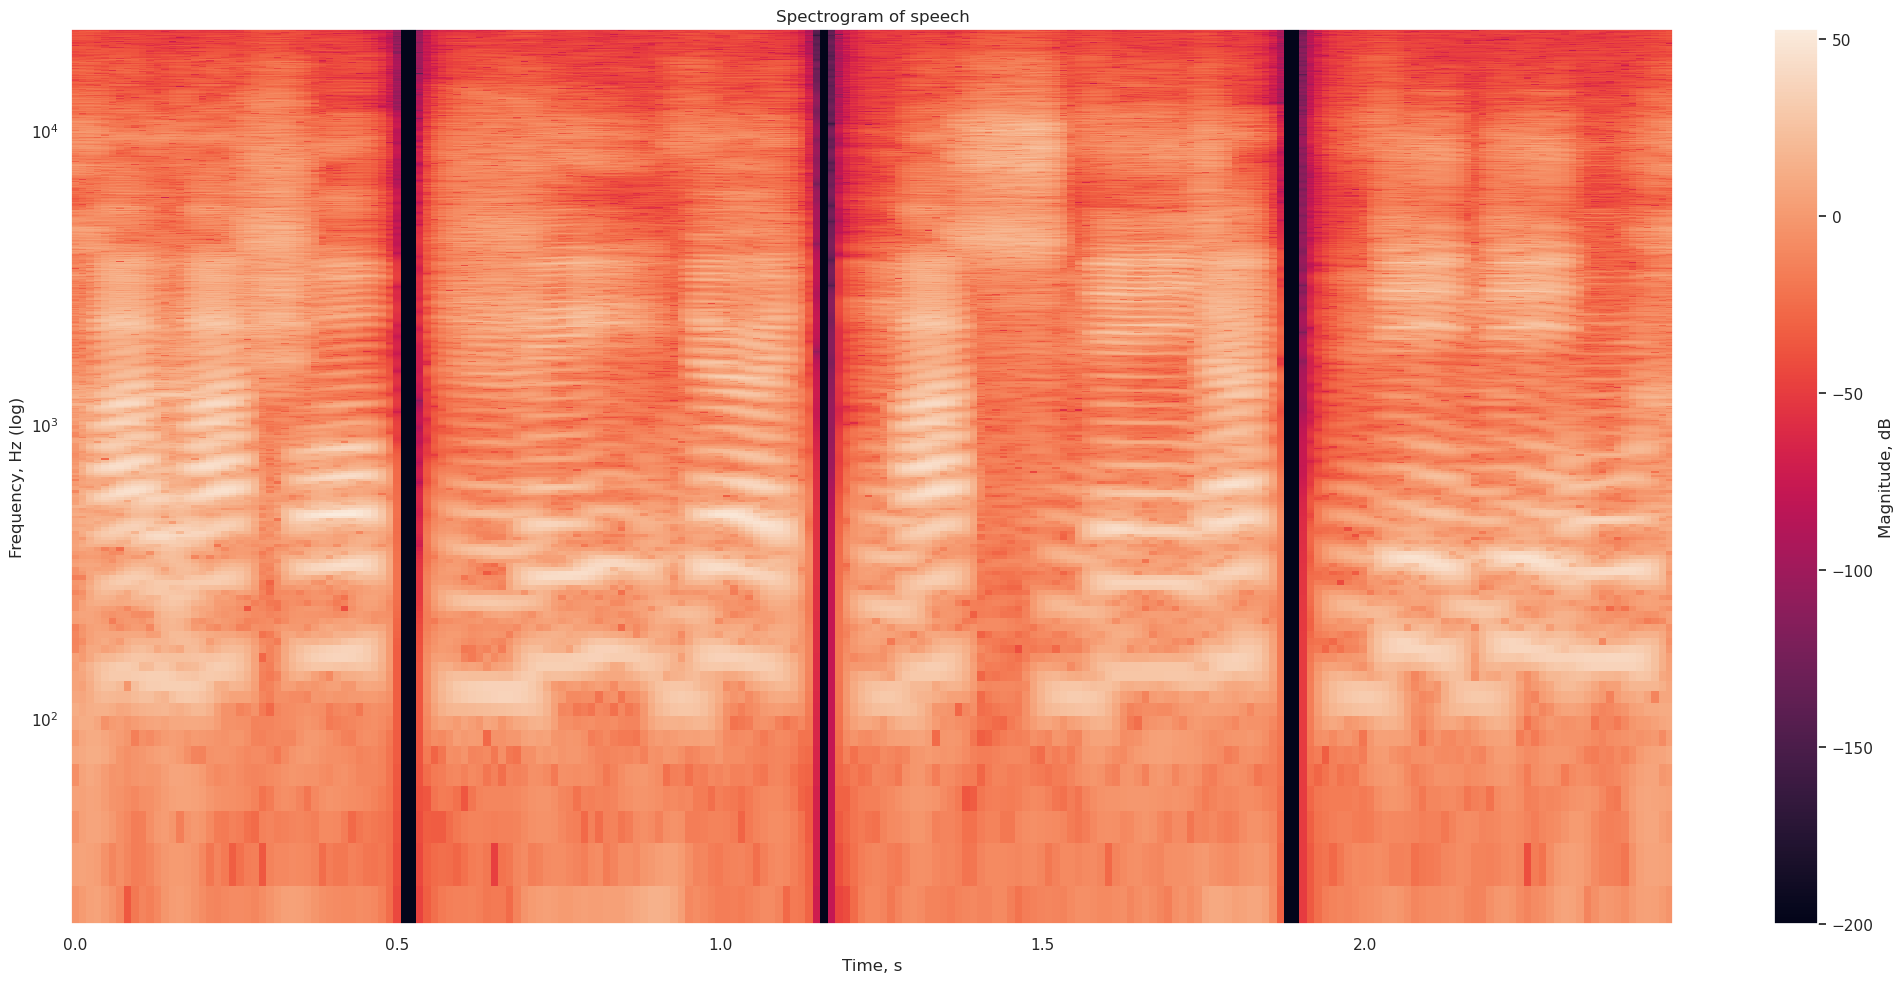

In [17]:
plot_spectrogram(
    X,
    sample_rate=sr,
    hop=hop,
    title="Spectrogram of speech",
    path=DATA_DIR / "spectrogram_speech.png",
)

Звучит еще норм, но вообще не естестенно.

Мне кажется я плохо справился с разметкой звуков (или их записью).